In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/Data Mining

/content/drive/My Drive/Data Mining


In [0]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import json
import datetime as dt
import time as tm
import datetime
import matplotlib.pyplot as plt
import itertools as it
from zipfile import ZipFile

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from yellowbrick.cluster import KElbowVisualizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
with ZipFile('Power-Networks-LCL-June2015(withAcornGps).zip', 'r') as zipObj:
   zipObj.extractall()

# **Data Reading**

In [0]:
cd Power-Networks-LCL-June2015(withAcornGps).csv_Pieces

/content/drive/My Drive/Data Mining/Power-Networks-LCL-June2015(withAcornGps).csv_Pieces


In [0]:
aggregate = open('AggregatedFile.csv', 'w')
aggregate.write("CustomerID,StdorToU,DateTime,Acorn_grouped,KWH\n")

In [0]:
for f in it.chain(range(1, 91), range(165, 168)):
  print("On file #", f)
  datafile = pd.read_csv('Power-Networks-LCL-June2015(withAcornGps)v2_' + str(f) + '.csv')  
  datafile['KWH/hh (per half hour) '] = datafile['KWH/hh (per half hour) '].replace("Null", '0')
  datafile['KWH/hh (per half hour) '] = datafile['KWH/hh (per half hour) '].astype(float)
  datafile['DateTime'] = datafile['DateTime'].astype('datetime64[ns]')
  
  i = 0
  for j in range(1, 1000000):
    i += j
    if(i >= 1000000):
      break
    k = i

    day1 = datafile['DateTime'].iloc[i]
    total_energy = 0
    while((datafile['DateTime'].iloc[i].day == day1.day) and (datafile['DateTime'].iloc[i].month == day1.month)):
      total_energy += datafile['KWH/hh (per half hour) '].iloc[i]
      i+=1

    aggregate.write(str(datafile['LCLid'].iloc[k])+',')
    aggregate.write(str(datafile['stdorToU'].iloc[k])+',')
    aggregate.write(str(datafile['DateTime'].iloc[k])+',')
    aggregate.write(str(datafile['Acorn_grouped'].iloc[k])+',')
    aggregate.write(str(total_energy) +'\n')
  
aggregate.close()

In [0]:
dataCombined = pd.read_csv('AggregatedFile.csv')  
print(len(dataCombined))
backup = dataCombined.copy()

129177


# **Data Cleaning**

In [0]:
dataCombined['KWH'] = pd.to_numeric(dataCombined['KWH'])
dataCombined['DateTime'] = dataCombined['DateTime'].astype('datetime64[ns]')

In [0]:
dataCombined.head(10)

,CustomerID,StdorToU,DateTime,Acorn_grouped,KWH
0,MAC000002,Std,2012-10-12 01:00:00,Affluent,7.098
1,MAC000002,Std,2012-10-13 01:00:00,Affluent,10.555
2,MAC000002,Std,2012-10-14 01:30:00,Affluent,12.569
3,MAC000002,Std,2012-10-15 02:00:00,Affluent,9.744
4,MAC000002,Std,2012-10-16 02:30:00,Affluent,8.886
5,MAC000002,Std,2012-10-17 03:00:00,Affluent,9.975
6,MAC000002,Std,2012-10-18 03:30:00,Affluent,9.224
7,MAC000002,Std,2012-10-19 04:00:00,Affluent,7.408
8,MAC000002,Std,2012-10-20 04:00:00,Affluent,16.004
9,MAC000002,Std,2012-10-21 05:00:00,Affluent,21.306


In [0]:
dataCombined.shape

(129177, 5)

In [0]:
dataCombined.dtypes

CustomerID               object
StdorToU                 object
DateTime         datetime64[ns]
Acorn_grouped            object
KWH                     float64
dtype: object

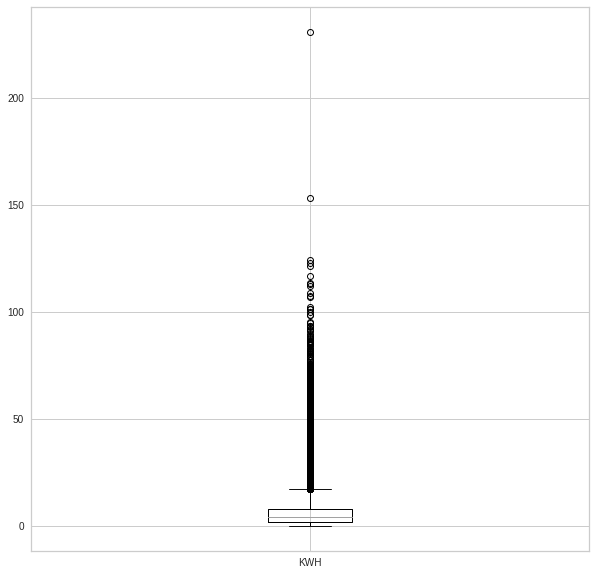

In [0]:
boxplot = dataCombined.boxplot(column='KWH', figsize = (10,10))

In [0]:
dataCombined.describe(include = "all")

,CustomerID,StdorToU,DateTime,Acorn_grouped,KWH
count,129177,129177,129177,129177,129177.000000
unique,3135,2,33908,4,NaN
top,MAC000200,Std,2013-01-02 11:00:00,Affluent,NaN
freq,248,125010,15,47507,NaN
first,NaN,NaN,2011-11-24 14:00:00,NaN,NaN
last,NaN,NaN,2014-02-28 00:00:00,NaN,NaN
mean,NaN,NaN,NaN,NaN,6.145356
std,NaN,NaN,NaN,NaN,6.993004
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,1.792000


# **Exploratory Data Analysis (EDA)**

In [0]:
# Finding out dependence between categorical and numerical attributes
Numerical = list(dataCombined._get_numeric_data().columns)
Categorical = list(["StdorToU", "Acorn_grouped"])
#Since STDorTour and Acorn_grouped are categorical attributes, we shall use encoding in order to calculate corr
#StdorToU only has two values, 0.0 or 1.0, so we're going to encode them
#Acorn_Grouped has 4 values: 'Affluent', 'Adversity', 'Comfortable', 'ACORN-U', we're going to encode them too
tempdf = dataCombined.copy()
newdf = dataCombined.copy()
print("Numerical Attributes: ", Numerical)
print("Categorical Attributes: ", Categorical)
myData=dataCombined
myData['StdorToU'] = myData['StdorToU'].astype('category')
myData['StdorToU'].cat.categories = [0,1]
myData['StdorToU'] = myData['StdorToU'].astype('float')
myData['Acorn_grouped'] = myData['Acorn_grouped'].astype('category')
myData['Acorn_grouped'].cat.categories = [0,1,2,3]
myData['Acorn_grouped'] = myData['Acorn_grouped'].astype('float')
print("\nTHE DEPENDANCY MATRIX\n")
myData.corr()
#AFFLUENT = 2.0
#ADVERSITY = 1.0
#COMFORTABLE = 3.0
#ACCORN_U = 0.0

Numerical Attributes:  ['KWH']
Categorical Attributes:  ['StdorToU', 'Acorn_grouped']

THE DEPENDANCY MATRIX



,StdorToU,Acorn_grouped,KWH
StdorToU,1.000000,0.017995,0.026930
Acorn_grouped,0.017995,1.000000,0.075788
KWH,0.026930,0.075788,1.000000


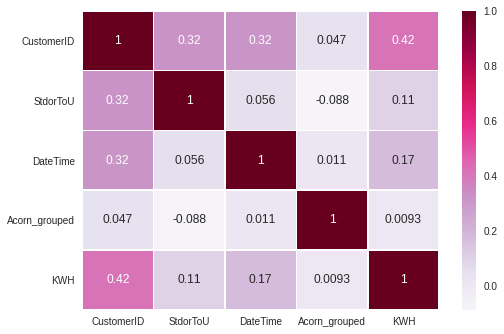

In [0]:
#Finding Out Correlation between Attributes
sns.heatmap(dataCombined.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1), cmap="PuRd", annot=True, linewidths=.5)

Text(0.5, 1.0, 'Average Daily Electricity Usage For Each Month between November 2011 and February 2014')

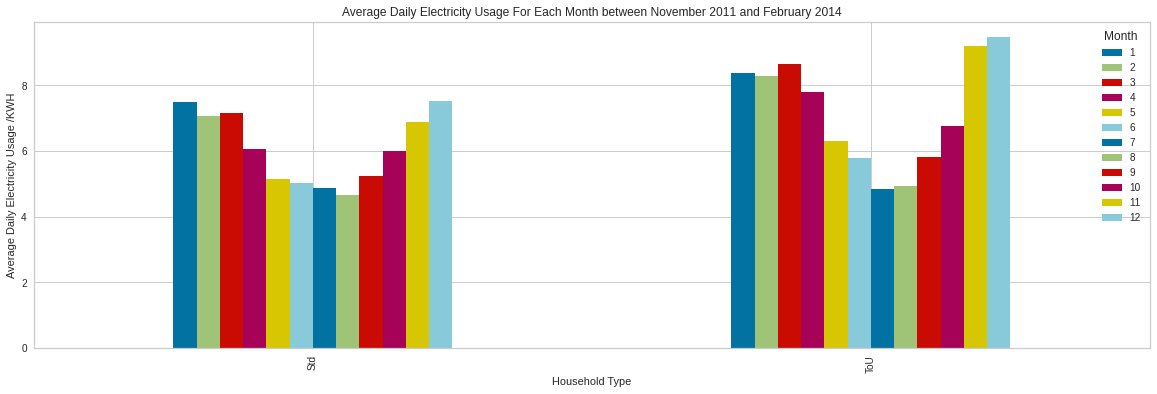

In [0]:
# Average energy usage in each month by each customer group
tempdf = tempdf.rename(columns={"DateTime": "Month"})
temp = tempdf['KWH'].groupby(by = [tempdf['StdorToU'], tempdf['Month'].dt.month]).mean().unstack().plot(kind='bar', figsize=(20,6))
plt.xlabel('Household Type')
plt.ylabel('Average Daily Electricity Usage /KWH')
plt.title('Average Daily Electricity Usage For Each Month between November 2011 and February 2014')

Text(0.5, 1.0, 'Average Electricity Usage On Each Date Of The Month between November 2011 and February 2014')

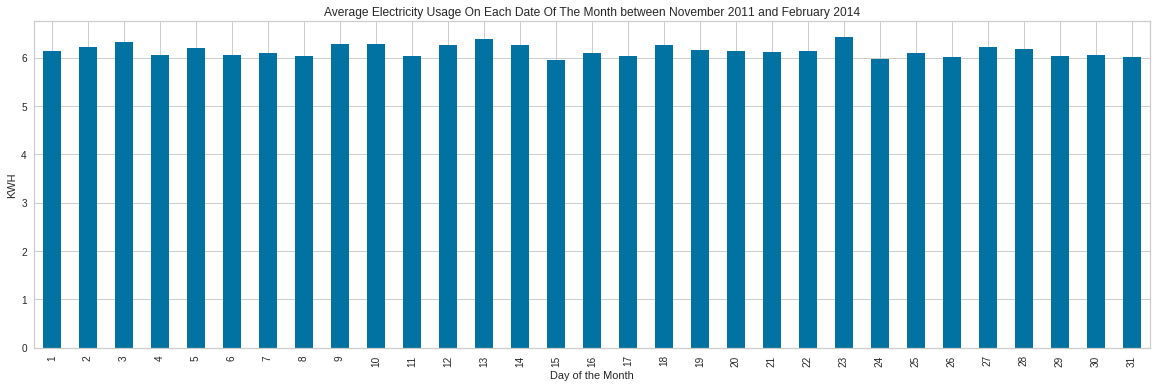

In [0]:
# Average Electricity Usage On Each Date Of The Month
Daily_Usage = dataCombined['KWH'].groupby(by = dataCombined['DateTime'].dt.day).mean()
plt.figure(figsize=(20,6))
Daily_Usage.plot.bar()
plt.xlabel('Day of the Month')
plt.ylabel('KWH')
plt.title('Average Electricity Usage On Each Date Of The Month between November 2011 and February 2014')

Text(0.5, 1.0, 'Average Electricity Usage In Each Week Of The Year between November 2011 and February 2014')

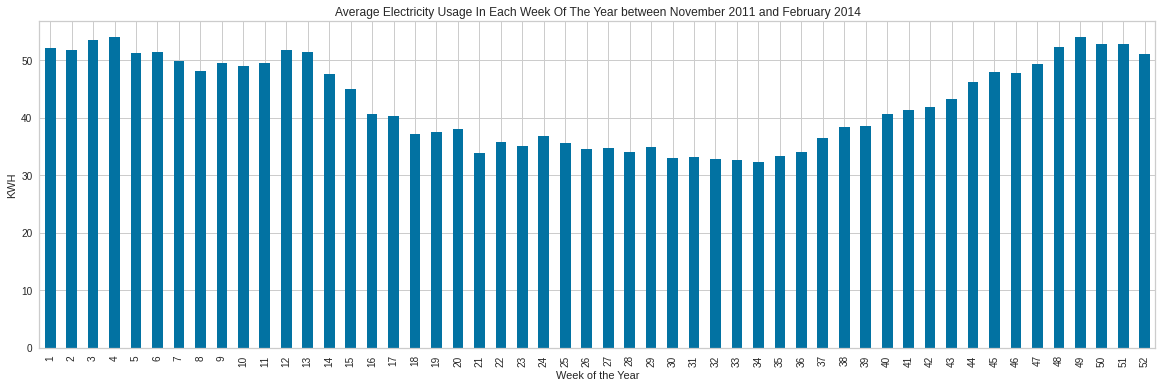

In [0]:
# Average Electricity Usage In Each Week Of The Year
Weekly_Usage = dataCombined.groupby(by = dataCombined['DateTime'].dt.week).mean()
Weekly_Usage = Weekly_Usage['KWH']*7
plt.figure(figsize=(20,6))
Weekly_Usage.plot.bar()
plt.xlabel('Week of the Year')
plt.ylabel('KWH')
plt.title('Average Electricity Usage In Each Week Of The Year between November 2011 and February 2014')

Text(0, 0.5, 'Average Energy Consumption /KWH')

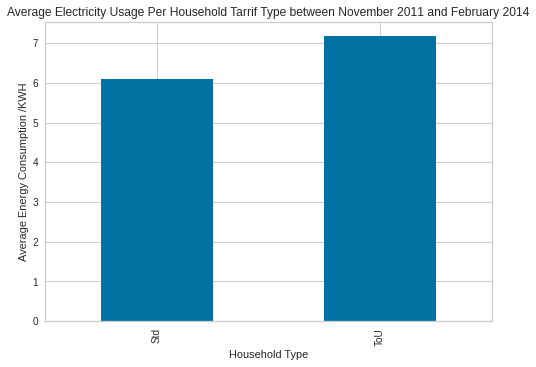

In [0]:
# Average Electricity Usage Per Household Tarrif Type
tempdf = dataCombined.copy()
Usage_per_household_type = tempdf.groupby('StdorToU').mean()
Usage_per_household_type = Usage_per_household_type.drop(['Acorn_grouped'], axis =1)
Usage_per_household_type['Household Type'] = ['Std', 'ToU']
Usage_per_household_type = Usage_per_household_type.reset_index()
Usage_per_household_type = Usage_per_household_type.set_index('Household Type')
Usage_per_household_type = Usage_per_household_type.drop(['StdorToU'], axis =1)
Usage_per_household_type.plot(kind='bar', legend=False)
plt.title('Average Electricity Usage Per Household Tarrif Type between November 2011 and February 2014')
plt.ylabel('Average Energy Consumption /KWH')

Text(0.5, 1.0, 'Average Electricity Usage per household per Season between November 2011 and February 2014')

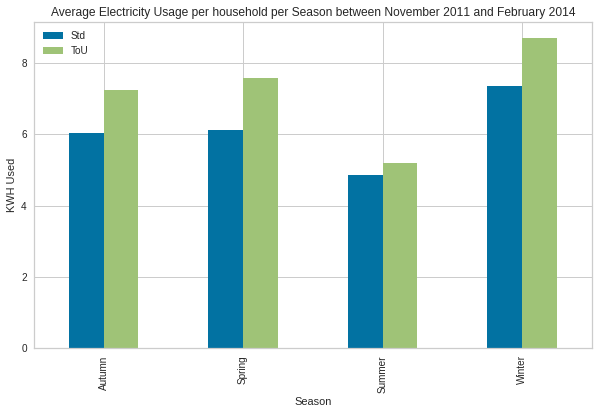

In [0]:
# Assuming the following details below
# Spring - March to May
# Summer - June to August
# Autumn - September to November
# Winter - December to February
# Source: http://projectbritain.com/weather/seasons.htm

Newdf = dataCombined.copy()
Newdf = Newdf.pivot_table(index=[Newdf['DateTime'].dt.month, 'StdorToU'], values='KWH', aggfunc='mean')
Spring = Newdf[4:10].groupby('StdorToU').sum()/3
Summer = Newdf[10:16].groupby('StdorToU').sum()/3
Autumn = Newdf[16:22].groupby('StdorToU').sum()/3
Winter = Newdf.iloc[[0,1,2,3,22,23]].groupby('StdorToU').sum()/3
Anotherdf = pd.concat([Spring, Summer, Autumn, Winter], keys=['Spring', 'Summer', 'Autumn', 'Winter'])
Anotherdf = Anotherdf.reset_index().set_index(['level_0', 'StdorToU'])
Anotherdf.unstack().plot(kind='bar', figsize=(10,6)).legend(["Std", "ToU"])
plt.xlabel('Season')
plt.ylabel('KWH Used')
plt.title('Average Electricity Usage per household per Season between November 2011 and February 2014')

# **Cluster Analysis**

In [0]:
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor



*   Partitional Clustering -> Better complexity on large datasets
*   Elbow Method for calculating clusters -> It helps in reaching an actual decision on what K value to use








### **(a)(i) Calculating the number of clusters**

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

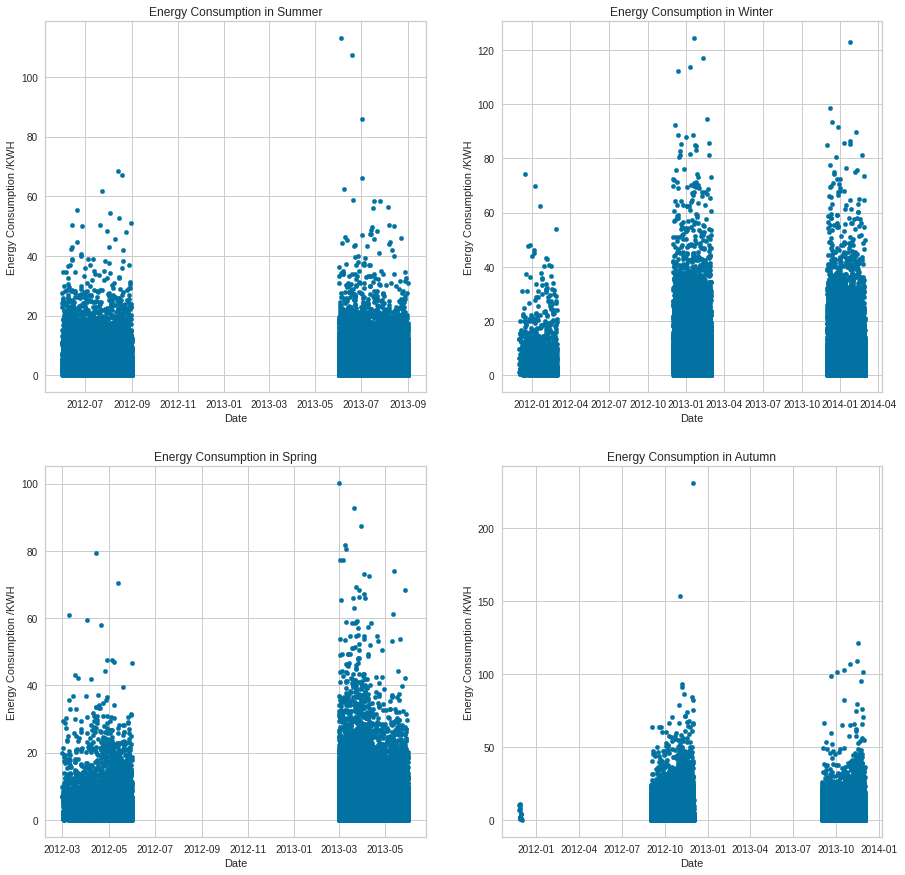

In [0]:
# Assuming the following details below
# Spring - March to May
# Summer - June to August
# Autumn - September to November
# Winter - December to February

# Changing Labels
# Summer = 1
# Winter = 2
# Spring = 3
# Autumn = 4

TempDf = dataCombined.copy()
newTemp = dataCombined.copy()
TempDf['Season'] = 0

TempDf.loc[(TempDf['DateTime'].dt.month>=6) & (TempDf['DateTime'].dt.month<=8), 'Season'] = 1
TempDf.loc[(TempDf['DateTime'].dt.month==12) | (TempDf['DateTime'].dt.month<=2), 'Season'] = 2
TempDf.loc[(TempDf['DateTime'].dt.month>=3) & (TempDf['DateTime'].dt.month<=5), 'Season'] = 3
TempDf.loc[(TempDf['DateTime'].dt.month>=9) & (TempDf['DateTime'].dt.month<=11), 'Season'] = 4

anothercopy = TempDf.copy() # DON'T DELETE

Seasons = ['Summer', 'Winter', 'Spring', 'Autumn']
counter = 0
fig = plt.figure(figsize=(15, 15))
for i in range(1, 5):
    lol = TempDf[TempDf['Season'] == i].plot.scatter('DateTime', 'KWH', title = 'Energy Consumption in '+Seasons[counter], ax = fig.add_subplot(2, 2, i))
    lol.set_xlabel('Date')
    lol.set_ylabel('Energy Consumption /KWH')
    counter += 1

### **(a)(ii) Applying Cluster Analysis**

In [0]:
AnotherDf = TempDf.copy()
AnotherDf = AnotherDf.drop(['DateTime', 'CustomerID'], axis =1)

xlabels = []
k_means_values = []

for i in range(1, 11):
  kmeanModel = KMeans(n_clusters=i, random_state=1).fit(AnotherDf) 
  k_means_values.append(kmeanModel.inertia_)
  xlabels.append(i)

Text(0, 0.5, 'Inertia Values')

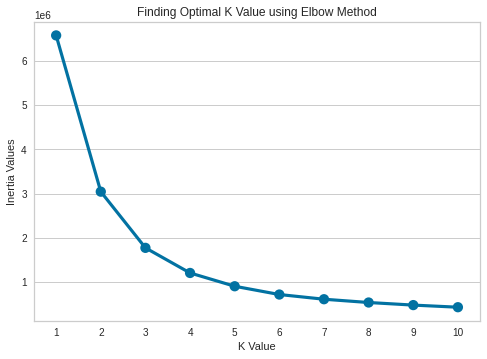

In [0]:
ax = sns.pointplot(x=xlabels, y=k_means_values)
plt.title('Finding Optimal K Value using Elbow Method')
plt.xlabel('K Value')
plt.ylabel('Inertia Values')

Text(0, 0.5, 'KWH')

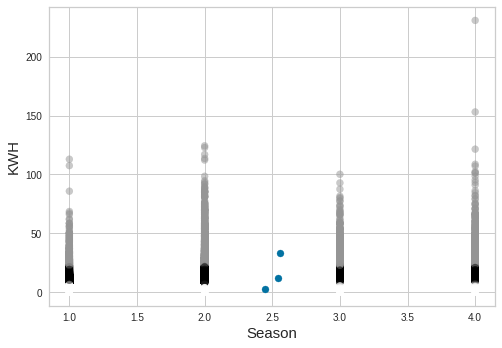

In [0]:
kmeans = KMeans(n_clusters = 3).fit(AnotherDf)
labels = kmeans.labels_
AnotherDf["labels"] = labels
centroids = kmeans.cluster_centers_
centroid_vals_x = []
centroid_vals_y = []
for i in range(len(centroids)):
  centroid_vals_x.append(centroids[i][3])
  centroid_vals_y.append(centroids[i][2])

plt.scatter(AnotherDf['Season'], AnotherDf['KWH'], c=labels.astype(np.float), alpha=0.5)
plt.scatter(centroid_vals_x, centroid_vals_y)
plt.xlabel('Season', fontsize=15)
plt.ylabel('KWH', fontsize=15)

Number of Unique Clusters 3


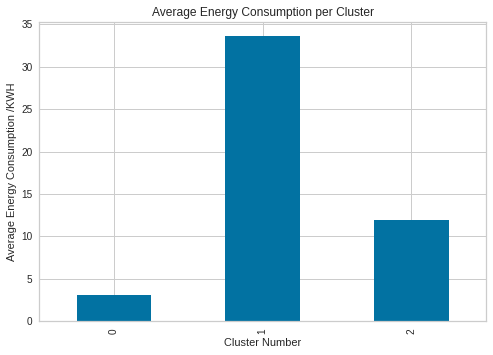

In [0]:
Average_KWH=pd.DataFrame(data={'Cluster No #':[0, 1, 2], 'Average KWH': [AnotherDf[AnotherDf["labels"]==0]["KWH"].mean(), AnotherDf[AnotherDf["labels"]==1]["KWH"].mean(), AnotherDf[AnotherDf["labels"]==2]["KWH"].mean()]})
Average_KWH = Average_KWH.set_index('Cluster No #')
Average_KWH.plot(kind='bar', legend = False)
plt.title('Average Energy Consumption per Cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Average Energy Consumption /KWH')
print("Number of Unique Clusters",len(AnotherDf.labels.unique()))

In [0]:
col_list = ['Cluster No #'] + Seasons

ClustersSeasonsCustID = pd.DataFrame(data={'Cluster No #':[0, 1, 2]}, columns=col_list)
ClustersSeasonsCustID = ClustersSeasonsCustID.set_index('Cluster No #')

ClustersSeasonsKWH = pd.DataFrame(data={'Cluster No #':[0, 1, 2]}, columns=col_list)
ClustersSeasonsKWH = ClustersSeasonsKWH.set_index('Cluster No #')

for i in range(3):
  for j in range(1, 5):
    ClustersSeasonsCustID.at[i, Seasons[j-1]] = AnotherDf.loc[(AnotherDf['labels']==i) & (AnotherDf['Season']==j)]['Season'].count()
    ClustersSeasonsKWH.at[i, Seasons[j-1]] = AnotherDf.loc[(AnotherDf['labels']==i) & (AnotherDf['Season']==j)]['KWH'].mean()

Text(0, 0.5, 'Count of Customers')

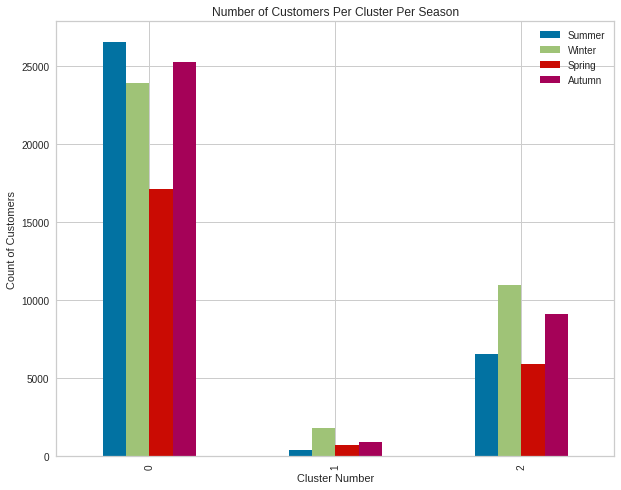

In [0]:
ClustersSeasonsCustID.plot(kind='bar', figsize=(10, 8)) 
plt.title("Number of Customers Per Cluster Per Season")
plt.xlabel('Cluster Number')
plt.ylabel('Count of Customers')

Text(0, 0.5, 'Average Energy Consumption /KWH')

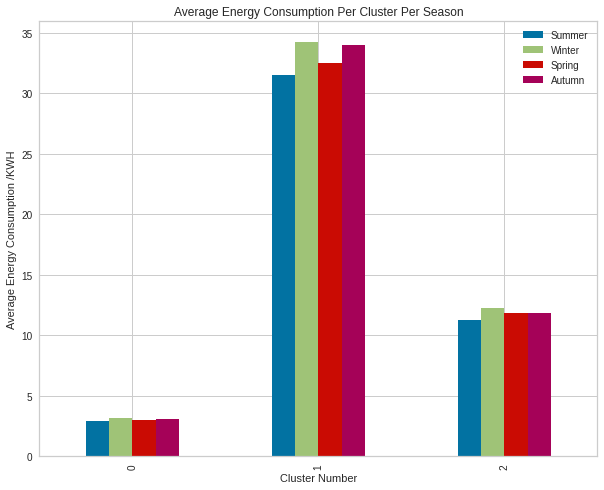

In [0]:
ClustersSeasonsKWH.plot(kind='bar', figsize=(10, 8))
plt.title("Average Energy Consumption Per Cluster Per Season")
plt.xlabel('Cluster Number')
plt.ylabel('Average Energy Consumption /KWH')

### **(b) Outlier Analysis**

In [0]:
outlierdf = anothercopy.copy() # Made from copy in scatterplot cell
outlierdf = outlierdf.drop(['CustomerID', 'StdorToU', 'DateTime',	'Acorn_grouped', 'Season'], axis=1)
outlierdf

,KWH
0,7.098
1,10.555
2,12.569
3,9.744
4,8.886
...,...
129172,1.733
129173,0.907
129174,4.070
129175,0.303


Text(0, 0.5, 'Value')

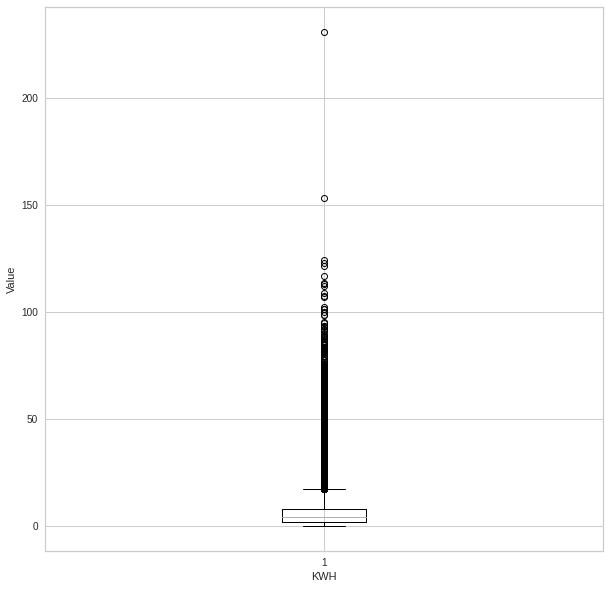

In [0]:
plt.figure(figsize=(10,10))
plt.boxplot(outlierdf['KWH'])
plt.xlabel('KWH')
plt.ylabel('Value')

In [0]:
min_max_scaler = MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(outlierdf)
outlierdf = pd.DataFrame(scaled_array)
outlierdf.columns = outlierdf.columns
outlierdf.head(10)

,0
0,0.030744
1,0.045718
2,0.054441
3,0.042205
4,0.038489
5,0.043205
6,0.039953
7,0.032087
8,0.069319
9,0.092284


In [0]:
clf = LocalOutlierFactor(n_neighbors=20)
labels = clf.fit_predict(outlierdf)
radius = (clf.negative_outlier_factor_.max() - clf.negative_outlier_factor_) / (clf.negative_outlier_factor_.max() - clf.negative_outlier_factor_.min())
outlierdf["Error"] = (-clf.negative_outlier_factor_)
outlierdf["Radius"] = radius
X = outlierdf
X

,0,Error,Radius
0,0.030744,0.992988,5.932101e-08
1,0.045718,0.967921,4.866510e-08
2,0.054441,1.035217,7.727240e-08
3,0.042205,0.981794,5.456224e-08
4,0.038489,1.143330,1.232308e-07
...,...,...,...
129172,0.007506,1.000004,6.230324e-08
129173,0.003929,1.000000,6.230169e-08
129174,0.017629,39.870399,1.658604e-05
129175,0.001312,1.000000,6.230169e-08


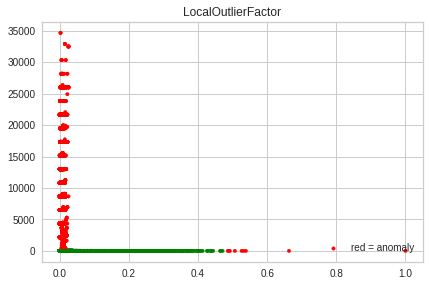

In [0]:
fig = plt.figure(figsize=(15,15))
def plot_model(labels, alg_name):
    ax = fig.add_subplot(3,2,1) 
    color_code = {-1:'red', 1:'green'}
    colors = [color_code[x] for x in labels]

    ax.scatter(X.iloc[:,0], X.iloc[:,1], color=colors, marker='.', label='red = anomaly')
    ax.legend(loc="lower right")

    leg = plt.gca().get_legend()
    leg.legendHandles[0].set_color('red')

    ax.set_title(alg_name)

plot_model(labels, 'LocalOutlierFactor')

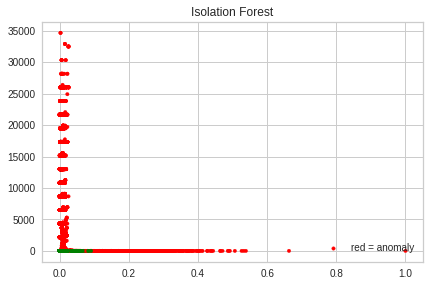

In [0]:
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples = 100, random_state = rng)
clf.fit(outlierdf)
y_pred_train = clf.predict(outlierdf)
y_pred_test = clf.predict(outlierdf)
labels = clf.predict(outlierdf)
X = outlierdf
fig = plt.figure(figsize = (15,15))
plot_model(labels, 'Isolation Forest')